Davide Ligabue,   MATR: 0001191187, davide.ligabue@studio.unibo.it  
Leonardo Benini,  MATR: 0001189330, leonardo.benini3@studio.unibo.it

# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/ColabNotebooks/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from dataclasses import dataclass
from skimage.util import random_noise

## Input analysis
The provided models and scenes show no appreciable sign of gaussian noise. A very small amount of salt-and-pepper noise is present in a couple scenes but, given the already low resolution and scale of the features to detect, we decided against using a median filter to remove this noise.  
The images are therefore simply loaded as is.

In [ ]:
scenes_paths = [f"dataset/scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [f"dataset/models/model_{i}.png" for i in range(22)]

scenes = [cv2.imread(path) for path in scenes_paths]
scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
models = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in model_paths]

In [ ]:
colors = [(0, 255, 0), (0, 0, 255), (255, 0, 0)]

def print_scene(model_instances, scene):
  print(f"Models: {[(i, len(m)) for i, m in enumerate(model_instances) if m != []]}")

  for model_bboxes, color in zip([m for m in model_instances if m != []], colors):
    points = [np.int32(bbox) for bbox in model_bboxes]
    scene = cv2.polylines(scene, points, True, color, 3, cv2.LINE_AA)

  plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
  plt.show()
  return

def print_detection_summary(model_instances):
  for model_idx, instances in enumerate(model_instances):
    if instances:
      print(f"Book {model_idx} – {len(instances)} instance(s) found:")
    for k, bbox in enumerate(instances, 1):
      pts = np.int32(bbox)
      area = int(cv2.contourArea(pts))
      top_left, bottom_left, bottom_right, top_right = [tuple(int(x) for x in pt) for pt in pts]

      print(f"  Instance {k} {{top_left: {top_left}, top_right: {top_right}, "
            f"bottom_left: {bottom_left}, bottom_right: {bottom_right}, "
            f"area: {area}px}}")

The main function is `instance_in_scene`, which given a scene image and a model image returns the (possibly found) instance of the model image in the scene image, as its bounding box.

Main steps of the function:
- Keypoints and descriptors are computed using SIFT for the scene image
- Descriptors are matched to the model image descriptors using a Brute Force Matcher
- The Lowe's ratio rule is applied to discard irrelevant matches,
- If the number of the remaining matches is beyond a certain threshold an homography is estimated, using RANSAC, which is used to project the corner points of the model image into the scene image,
- The found instances are checked to see if they meet some requirements, in particular:
 - `cv2.isContourConvex` return True if and only if all the internal angles of the detected instance are less or equal to $180^°$,
 - `compute_rectangularity` returns the ratio between the area of the bounding rectangle and the area of the actual detected instance ($\in [0, 1]$)
- The detected instance is masked with black in the scene image to avoid detecting it again and therefore achieve multi-instance object detection
- The corners point of the found instance are returned.



In [ ]:
def compute_rectangularity(bounds):
    x, y, w, h = cv2.boundingRect(bounds)
    bounds_area = cv2.contourArea(bounds)
    rect_area = w * h
    rectangularity = bounds_area / rect_area
    return rectangularity

@dataclass
class ProcessedModel:
  image: np.array
  keypoints: np.array
  descriptors: np.array

lowes_ratio = 0.72
min_match_percent = 0.01
ransac_error = 3

def instance_in_scene(processed_model: ProcessedModel, img_scene: np.array, debug=False):
  # SIFT feature extraction on the scene
  sift_scene = cv2.SIFT_create(sigma=0.4)
  kp_scene, des_scene = sift_scene.detectAndCompute(img_scene, None)

  # Feature matching
  matcher = cv2.BFMatcher()
  matches = matcher.knnMatch(processed_model.descriptors, des_scene, k=2)

  # Apply Lowe's ratio test
  good_matches = []
  for m, n in matches:
      if m.distance < lowes_ratio * n.distance:
          good_matches.append(m)

  if len(good_matches) < min_match_percent * len(matches):
    return None

  h, w = processed_model.image.shape
  pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]])

  # Extract source and destination points
  src_pts = np.float32([processed_model.keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

  try:
    # Compute homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_error)

    if M is None or mask is None:
        return None
  except:
    return None

  # Transform model corners to scene coordinates
  dst = cv2.perspectiveTransform(np.array([pts]), M)

  # Check if the found homography is good
  area = int(cv2.contourArea(dst))
  if not cv2.isContourConvex(dst) or area < 20 or compute_rectangularity(dst) < 0.6:
      return None

  # Mask scene
  img_scene = cv2.fillPoly(img_scene, [np.int32(dst)], (0, 0, 0))

  # Drawing the matches
  if debug:
    img_debug = cv2.drawMatches(
        img1=processed_model.image, keypoints1=processed_model.keypoints,
        img2=img_scene, keypoints2=kp_scene,
        matches1to2=good_matches, matchesMask=mask.ravel().tolist(),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.imshow(img_debug)
    plt.show()

  dst = dst[0,:,:]
  return dst

The main execution block returns all the instances found of every model image in all the scene images.

Every model image is run on each scene image and, for a better result, just the first instance from each model image is returned (if found), this is repeated until no model has any matches in the scene. This way only the strongest matches are considered at every iteration.

---

The results (bounding boxes of found instances) are stored in a 3D tensor for later printing in the required format.

Detecting scene 0
Models: []


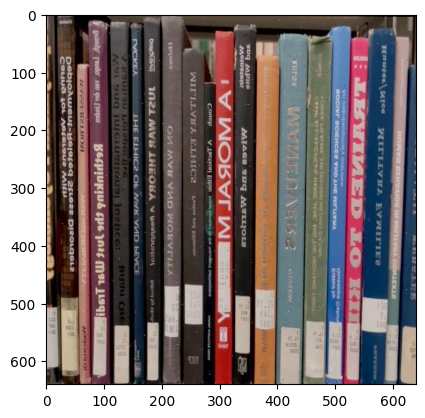

Detecting scene 1
Models: [(18, 2)]


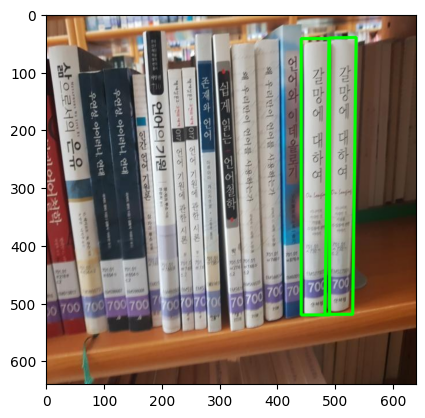

Detecting scene 2
Models: [(17, 1)]


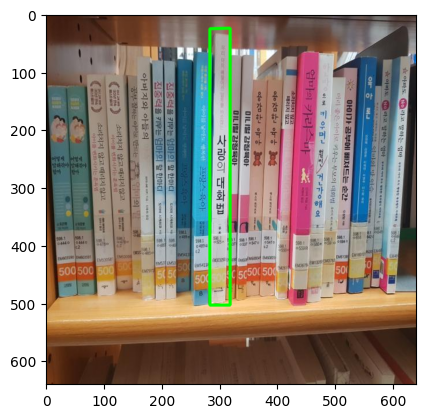

Detecting scene 3
Models: [(16, 2)]


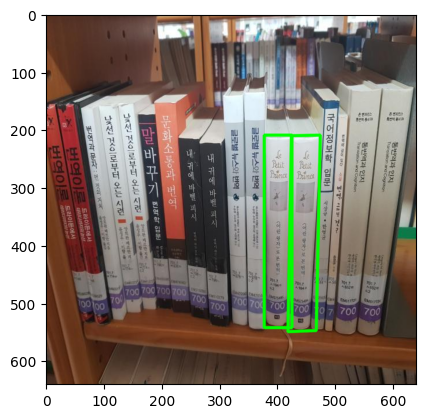

Detecting scene 4
Models: [(14, 2), (15, 2)]


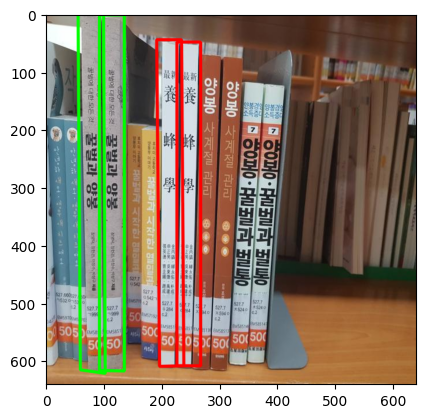

Detecting scene 5
Models: [(13, 1)]


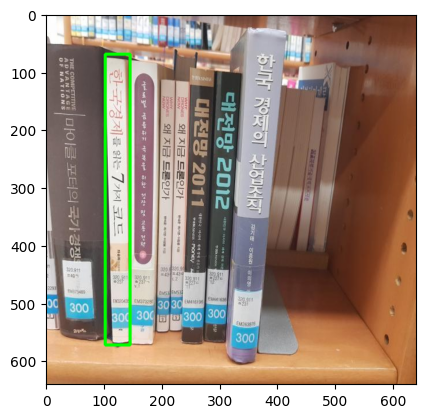

Detecting scene 6
Models: [(21, 1)]


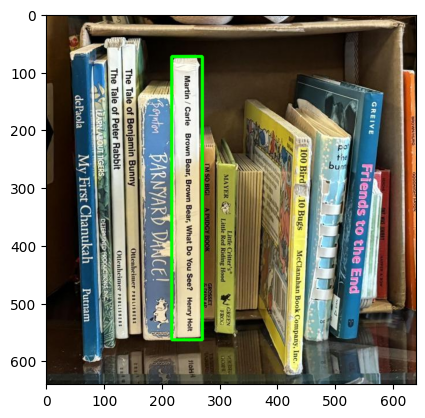

Detecting scene 7
Models: [(20, 2)]


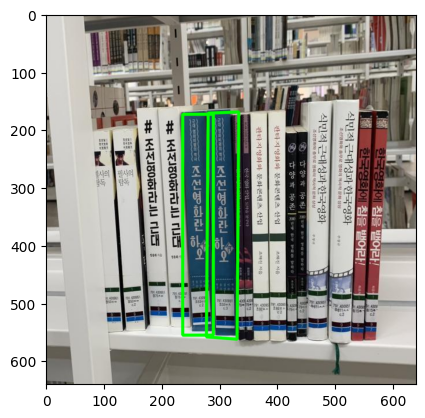

Detecting scene 8
Models: []


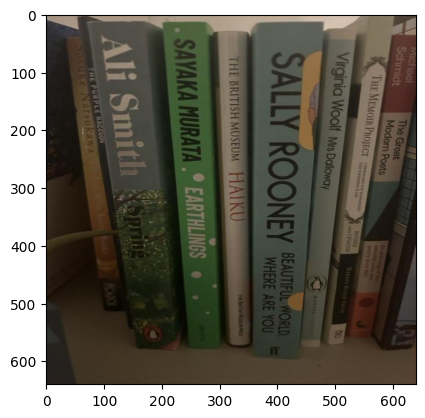

Detecting scene 9
Models: [(19, 4)]


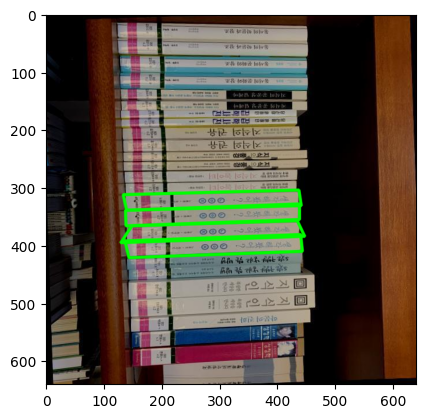

Detecting scene 10
Models: [(19, 4)]


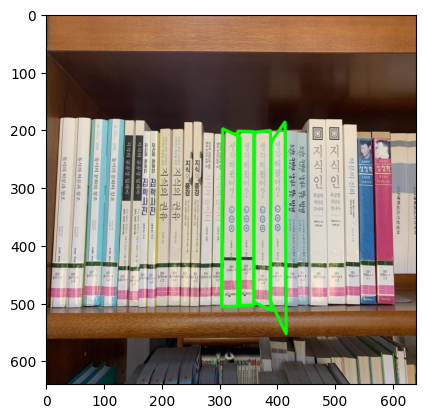

Detecting scene 11
Models: []


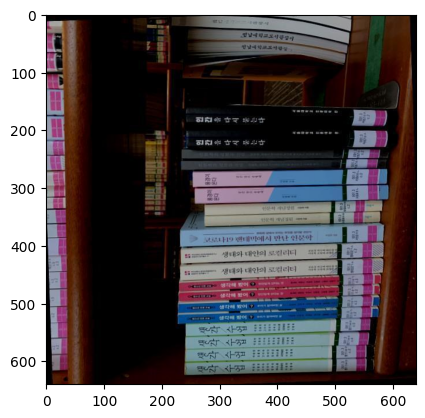

Detecting scene 12
Models: []


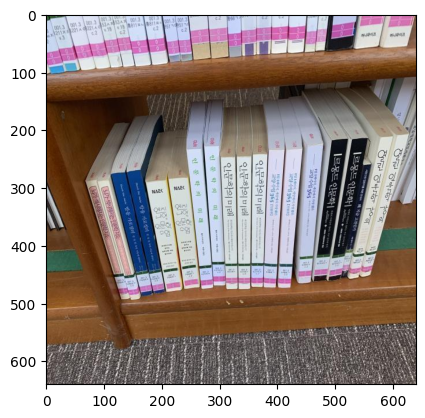

Detecting scene 13
Models: []


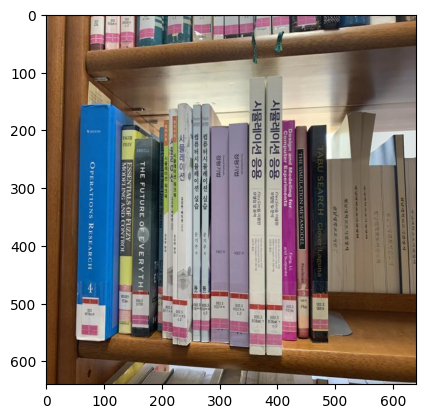

Detecting scene 14
Models: []


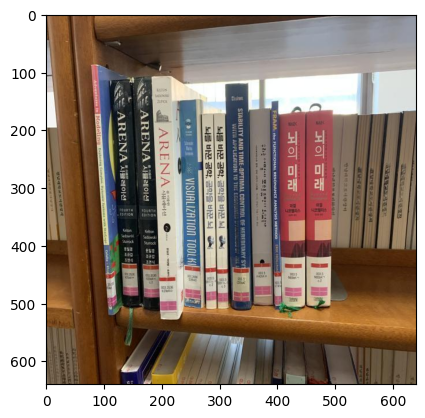

Detecting scene 15
Models: [(11, 2), (12, 3)]


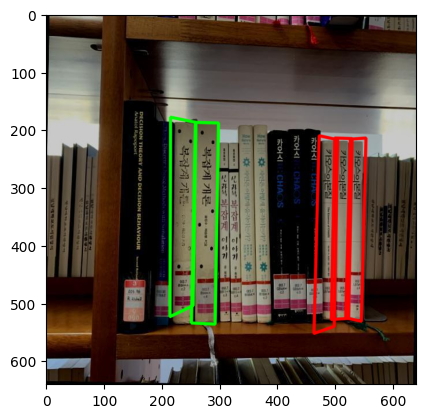

Detecting scene 16
Models: [(11, 2), (12, 3)]


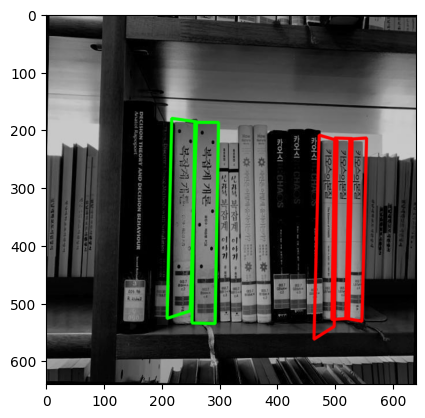

Detecting scene 17
Models: [(11, 2), (12, 3)]


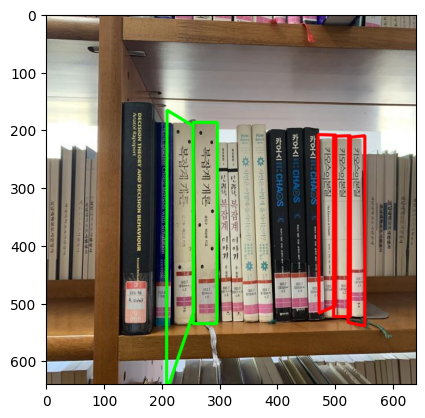

Detecting scene 18
Models: [(8, 2), (9, 1), (10, 3)]


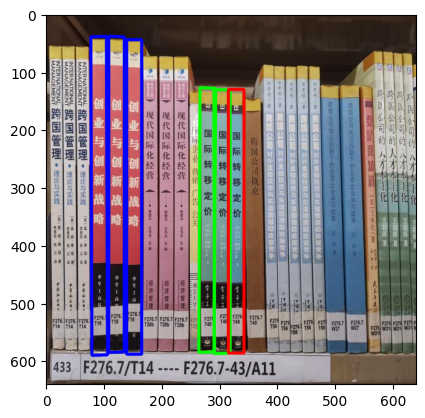

Detecting scene 19
Models: [(6, 3), (7, 2)]


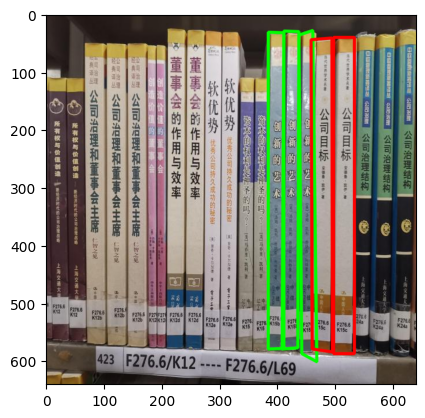

Detecting scene 20
Models: []


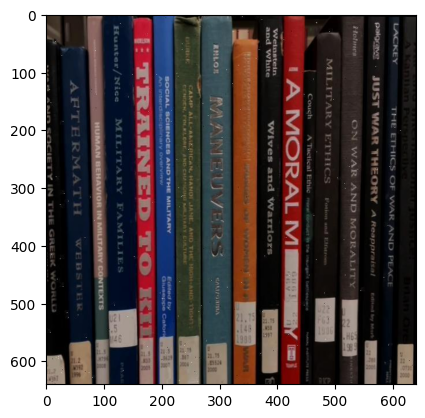

Detecting scene 21
Models: []


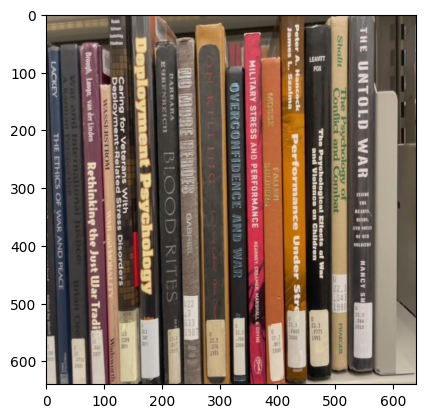

Detecting scene 22
Models: []


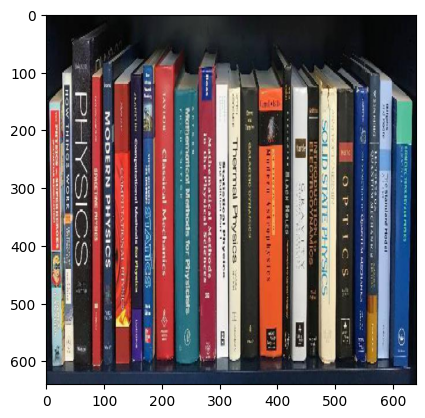

Detecting scene 23
Models: [(5, 1)]


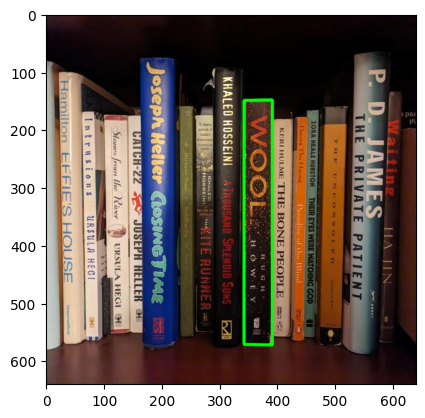

Detecting scene 24
Models: []


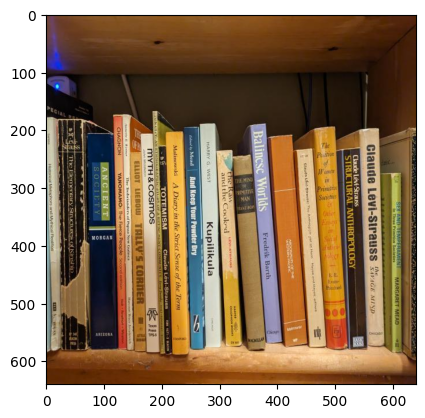

Detecting scene 25
Models: []


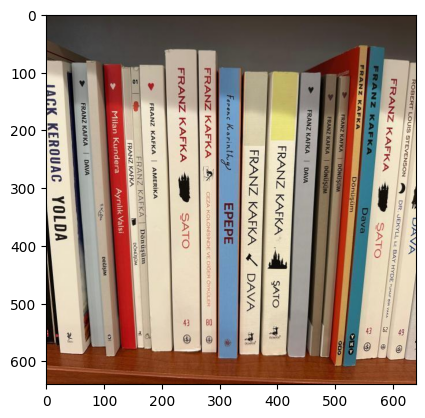

Detecting scene 26
Models: [(0, 2), (4, 1)]


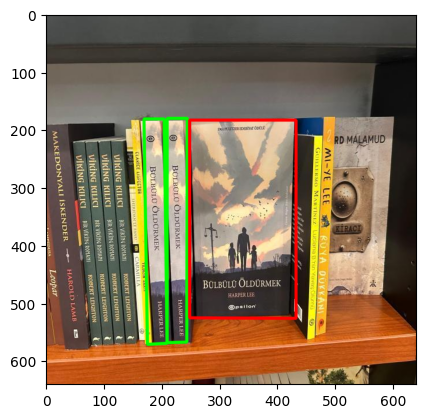

Detecting scene 27
Models: [(2, 2), (3, 2)]


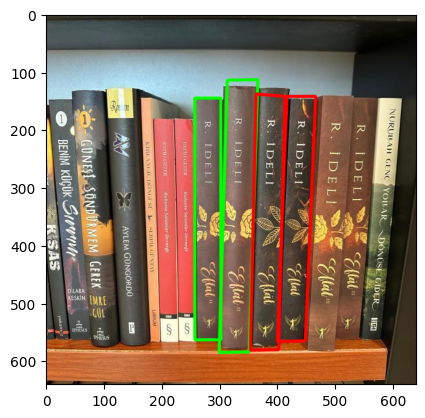

Detecting scene 28
Models: [(1, 2)]


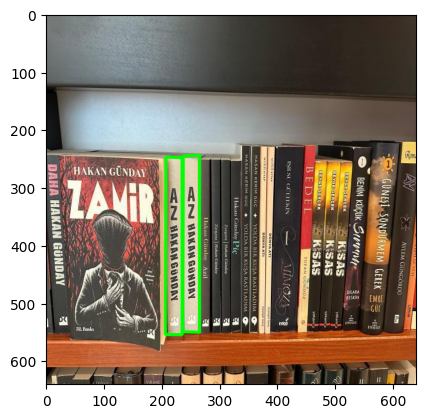

In [ ]:
results = [[[] for _ in range(len(models))] for _ in range(len(scenes))]

sift = cv2.SIFT_create(sigma=0.475)
processed_models = [ProcessedModel(model, *sift.detectAndCompute(model, None)) for model in models]

for j, (scene, scene_gray) in enumerate(zip(scenes, scenes_grayscale)):
  print(f"Detecting scene {j}")
  model_finished = [False] * len(processed_models)

  while not np.all(model_finished):
    for i, model in enumerate(processed_models):
      if model_finished[i]:
        continue

      instance = instance_in_scene(model, scene_gray)
      if instance is not None:
        results[j][i].append(instance)
      else:
        model_finished[i] = True

  print_scene(results[j], scene)

In [ ]:
# Print only the detection summary for a final standard output
for j, scene in enumerate(scenes):
  print(f"Scene {j}")
  if not any(len(instances) > 0 for instances in results[j]):
    print("No books found")
  else:
    print_detection_summary(results[j])

Scene 0
No books found
Scene 1
Book 18 – 2 instance(s) found:
  Instance 1 {top_left: (441, 42), top_right: (490, 42), bottom_left: (441, 520), bottom_right: (490, 520), area: 23422px}
  Instance 2 {top_left: (489, 41), top_right: (536, 40), bottom_left: (482, 519), bottom_right: (530, 519), area: 22725px}
Scene 2
Book 17 – 1 instance(s) found:
  Instance 1 {top_left: (283, 25), top_right: (318, 24), bottom_left: (283, 503), bottom_right: (318, 503), area: 16747px}
Scene 3
Book 16 – 2 instance(s) found:
  Instance 1 {top_left: (377, 209), top_right: (425, 209), bottom_left: (377, 542), bottom_right: (425, 542), area: 15984px}
  Instance 2 {top_left: (424, 210), top_right: (474, 209), bottom_left: (418, 549), bottom_right: (467, 547), area: 16746px}
Scene 4
Book 14 – 2 instance(s) found:
  Instance 1 {top_left: (92, 1), top_right: (135, 1), bottom_left: (92, 616), bottom_right: (135, 617), area: 26466px}
  Instance 2 {top_left: (55, -2), top_right: (99, -4), bottom_left: (59, 615), bott